In [1]:
import datetime

def get_expired_week_of_month():
    # 获取今天的日期和时间
    # Calculate the expiry date of the current weekly options
    today = datetime.date.today()
    
    # limit the expiry date to be a Friday
    expiry_date = today + datetime.timedelta(days=(4 - max(0, min(today.weekday(), 4))) % 7 + 1)

    week_of_month = (expiry_date.day-1)//7 + 1
    
    return week_of_month

# 生成本周的台指期权代码
prefix = 'TX'
code = prefix + str(get_expired_week_of_month())

# 打印结果
print("本周的台指期权代码为：", code)

    

本周的台指期权代码为： TX2


In [3]:
import exchange_calendars as xcals
import datetime

xtai = xcals.get_calendar("XTAI")

today = datetime.date.today()

prev_close_date = xtai.previous_close(today.strftime("%Y-%m-%d")).strftime("%Y/%m/%d")

prev_close_date


'2023/04/07'

In [4]:
def synthetic_futures_price(strike_price: float, call_price: float, call_volume: float, put_price: float, put_volume: float):
    print(f"strike_price: {strike_price}")
    print(f"call_price: {call_price}, call_volume: {call_volume}")
    print(f"put_price: {put_price}, put_volume: {put_volume}")
    
    volume = call_volume + put_volume
    
    if volume == 0:
        delta = 0
    else:
        delta = (call_price * call_volume - put_price * put_volume)/volume
    
    combine_price = strike_price - delta
    combine_volume = call_price * call_volume + put_price * put_volume
        
    return combine_price, combine_volume

In [16]:
from bs4 import BeautifulSoup
from io import StringIO
import pandas as pd
import requests
import datetime

today = datetime.date.today()
yesterday = today - datetime.timedelta(days=1)
code = today.strftime("%Y%m") + "W" + str(get_expired_week_of_month())

url = "https://www.taifex.com.tw/cht/3/dlOptDataDown"
data = {
    'down_type': 1,
    'commodity_id': 'TXO',
    'queryStartDate': prev_close_date,
    'queryEndDate':  prev_close_date
}

response = requests.post(url, data=data)
response.encoding = 'big5'
html_doc = response.content

print(html_doc)

# Parse the HTML content of the response using BeautifulSoup
soup = BeautifulSoup(html_doc, 'html.parser')
csv_str = str(soup)
print(csv_str)

with open('./output.csv', 'w', encoding='utf-8') as file:
    file.write(csv_str)

csv = pd.read_csv('./output.csv', index_col=False)
print(csv)
options = csv[(csv["到期月份(週別)"] == code) & (csv["交易時段"] == "一般")]
calls = options[options["買賣權"] == "買權"]
puts = options[options["買賣權"] == "賣權"]
prices = options["履約價"].drop_duplicates()

table = pd.DataFrame(columns=["combine_price", "combine_volume"])

for price in prices:
    call = calls[calls["履約價"] == price]
    
    strike_price = float(price)
    call_price = 0
    call_valume = 0
    put_price = 0
    put_volume = 0
    
    try:
        call_price = float(call["收盤價"])
    except ValueError:
        call_price = 0
        
    call_volume = float(call["未沖銷契約數"])
    
    put = puts[puts["履約價"] == price]
    
    try:
        put_price = float(put["收盤價"])
    except ValueError:
        put_price = 0
    
    put_volume = float(put["未沖銷契約數"])
    
    combine_price, combine_volume = synthetic_futures_price(
            strike_price=strike_price, call_price=call_price, call_volume=call_volume, put_price=put_price, put_volume=put_volume)

    row = pd.DataFrame({'combine_price': combine_price, 'combine_volume': combine_volume}, index=[0])
    table = pd.concat([table, row], ignore_index=True)

# round the table digits 2 and print the result
table = round(table, 0)
print(f"table = \n{table}")

b'\xa5\xe6\xa9\xf6\xa4\xe9\xb4\xc1,\xab\xb4\xac\xf9,\xa8\xec\xb4\xc1\xa4\xeb\xa5\xf7(\xb6g\xa7O),\xbci\xac\xf9\xbb\xf9,\xb6R\xbd\xe6\xc5v,\xb6}\xbdL\xbb\xf9,\xb3\xcc\xb0\xaa\xbb\xf9,\xb3\xcc\xa7C\xbb\xf9,\xa6\xac\xbdL\xbb\xf9,\xa6\xa8\xa5\xe6\xb6q,\xb5\xb2\xba\xe2\xbb\xf9,\xa5\xbc\xa8R\xbeP\xab\xb4\xac\xf9\xbc\xc6,\xb3\xcc\xab\xe1\xb3\xcc\xa8\xce\xb6R\xbb\xf9,\xb3\xcc\xab\xe1\xb3\xcc\xa8\xce\xbd\xe6\xbb\xf9,\xbe\xfa\xa5v\xb3\xcc\xb0\xaa\xbb\xf9,\xbe\xfa\xa5v\xb3\xcc\xa7C\xbb\xf9,\xacO\xa7_\xa6]\xb0T\xae\xa7\xad\xb1\xbc\xc8\xb0\xb1\xa5\xe6\xa9\xf6,\xa5\xe6\xa9\xf6\xae\xc9\xacq,\xba\xa6\xb6^\xbb\xf9,\xba\xa6\xb6^%\r\n2023/04/07,TXO,202304W2,14100.0000,\xb6R\xc5v,1740,1770,1740,1770,2,1730,1,1720,1750,1770,1610,,\xa4@\xaf\xeb,90,5.36%,\r\n2023/04/07,TXO,202304W2,14100.0000,\xb6R\xc5v,-,-,-,-,0,-,-,-,-,-,-,,\xbdL\xab\xe1,-,-,\r\n2023/04/07,TXO,202304W2,14100.0000,\xbd\xe6\xc5v,-,-,-,-,0,0.1,131,-,-,-,-,,\xa4@\xaf\xeb,-,-,\r\n2023/04/07,TXO,202304W2,14100.0000,\xbd\xe6\xc5v,-,-,-,-,0,-,-,-,

KeyError: '到期月份(週別)'

In [6]:
# get the window size of the first combine_price - last combine_price is less than 300.0
def get_window_size(table:pd.DataFrame, index:int=0, price_range:float=300.0, min_size:int=4):
    if index >= len(table):
        return 0, index
    
    # get the subtable from index to the end
    subtable = table[index:len(table)]
    window_size = 0
    start_price = 0.0
    
    for i in range(len(subtable)):
        if i == 0:
            start_price = subtable.iloc[i].at["combine_price"]
        elif i == len(subtable) - 1:
            window_size = i
        else:
            if table.iloc[i].at["combine_price"] > start_price + price_range:
                window_size = i
                break
    
    if len(subtable) - window_size < min_size:
        window_size = len(subtable)
        
    return window_size, index + window_size

In [7]:
import numpy as np
from scipy.stats import zscore
from scipy.stats import norm

index = 0
window_size = 0
combined_outliers = pd.DataFrame(columns=["combine_price", "combine_volume"])

while index < len(table) - 1:
    window_size, index = get_window_size(table, index) 
    subtable = table[index:index+window_size]
    
    # get the outliers of the subtable by zscore and 95th percentile
    outliers = subtable[np.abs(zscore(subtable['combine_volume'])) > norm.ppf(0.95)]
    
    # combine the outliers of the subtable and remove the duplicates
    combined_outliers = pd.concat([combined_outliers, outliers], ignore_index=True)
    # remove the duplicates with the samoe combine_price
    # combined_outliers = combined_outliers.drop_duplicates(subset=['combine_price'], keep='first')
    print('subtable[0] = ', subtable.iloc[0].at["combine_price"])
    print('window_size =', window_size)
    print('index =', index)
    print('combined_outliers =\n', combined_outliers)

print(f"combined_outliers = \n{combined_outliers}")


# Calculate z-scores
# z_scores = zscore(data)

# Define outlier threshold
# outlier_threshold = norm.ppf(0.95)

# Identify local outliers
# outliers = round(table[np.abs(z_scores) > outlier_threshold])

#print(f"table :\n{table}")
# print(f"outliers :\n{outliers}")



NameError: name 'table' is not defined

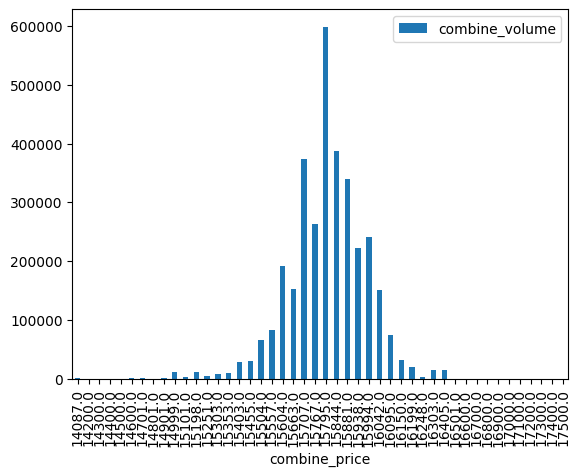

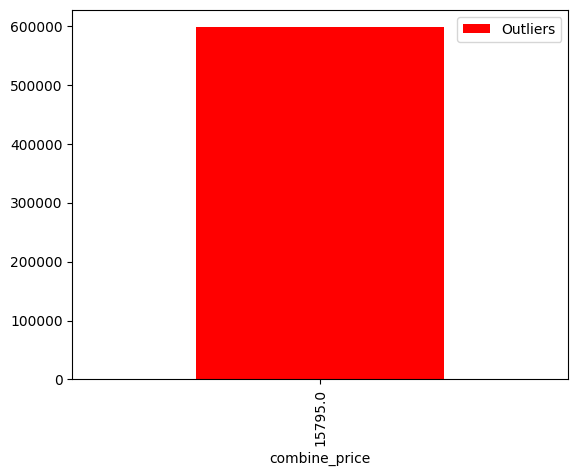

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# plt.scatter(table.index, table, label='Data')
# 繪製長條圖 x = combine_price y = combine_volume

table.plot.bar(x='combine_price', y='combine_volume')
combined_outliers.plot.bar(x='combine_price', y='combine_volume', color='red', label='Outliers')
plt.legend()
plt.show()

# plt.scatter(combined_outliers.index, combined_outliers['combine_volume'], color='red', label='Outliers')
# plt.legend()
# plt.show()

In [20]:
from bs4 import BeautifulSoup
from io import StringIO
import pandas as pd
import requests
import datetime

today = datetime.date.today()
yesterday = today - datetime.timedelta(days=1)
code = today.strftime("%Y%m") + "W" + str(get_expired_week_of_month())

url = "https://www.taifex.com.tw/cht/3/dlOptDataDown"
data = {
    'down_type': 1,
    'commodity_id': 'TXO',
    'queryStartDate': '2023/04/06',
    'queryEndDate':  '2023/04/06'
}

response = requests.post(url, data=data)
response.encoding = response.apparent_encoding#'utf-8'
html_doc = response.content

print(html_doc)

# Parse the HTML content of the response using BeautifulSoup
soup = BeautifulSoup(html_doc, "html.parser")
#soup.encoding = 'utf-8'
csv_str = str(soup)
print(csv_str)
#print(csv_str.encode('utf-8').decode())

b'\xa5\xe6\xa9\xf6\xa4\xe9\xb4\xc1,\xab\xb4\xac\xf9,\xa8\xec\xb4\xc1\xa4\xeb\xa5\xf7(\xb6g\xa7O),\xbci\xac\xf9\xbb\xf9,\xb6R\xbd\xe6\xc5v,\xb6}\xbdL\xbb\xf9,\xb3\xcc\xb0\xaa\xbb\xf9,\xb3\xcc\xa7C\xbb\xf9,\xa6\xac\xbdL\xbb\xf9,\xa6\xa8\xa5\xe6\xb6q,\xb5\xb2\xba\xe2\xbb\xf9,\xa5\xbc\xa8R\xbeP\xab\xb4\xac\xf9\xbc\xc6,\xb3\xcc\xab\xe1\xb3\xcc\xa8\xce\xb6R\xbb\xf9,\xb3\xcc\xab\xe1\xb3\xcc\xa8\xce\xbd\xe6\xbb\xf9,\xbe\xfa\xa5v\xb3\xcc\xb0\xaa\xbb\xf9,\xbe\xfa\xa5v\xb3\xcc\xa7C\xbb\xf9,\xacO\xa7_\xa6]\xb0T\xae\xa7\xad\xb1\xbc\xc8\xb0\xb1\xa5\xe6\xa9\xf6,\xa5\xe6\xa9\xf6\xae\xc9\xacq,\xba\xa6\xb6^\xbb\xf9,\xba\xa6\xb6^%\r\n2023/04/06,TXO,202304W1,13900.0000,\xb6R\xc5v,-,-,-,-,0,0,1,-,-,-,-,,\xa4@\xaf\xeb,-,-,\r\n2023/04/06,TXO,202304W1,13900.0000,\xb6R\xc5v,-,-,-,-,0,-,-,-,-,-,-,,\xbdL\xab\xe1,-,-,\r\n2023/04/06,TXO,202304W1,13900.0000,\xbd\xe6\xc5v,-,-,-,-,0,0,156,-,-,-,-,,\xa4@\xaf\xeb,-,-,\r\n2023/04/06,TXO,202304W1,13900.0000,\xbd\xe6\xc5v,-,-,-,-,0,-,-,-,-,-,-,,\xbdL\xab\xe1,-,-,\r\n2023/

UnicodeDecodeError: 'gbk' codec can't decode byte 0xa5 in position 102: illegal multibyte sequence

In [8]:
print("中文")

中文
